In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")
sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
import cupy as cp

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# You can clear the memory pool by calling `free_all_blocks`.
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

In [5]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )

27-Feb-22 21:28:52 Loading position info...
27-Feb-22 21:29:36 Loading multiunit...
27-Feb-22 21:29:55 Loading spikes...
27-Feb-22 21:30:00 Finding ripple times...


In [6]:
from replay_identification import ReplayDetector
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from scipy.stats import zscore


def plot_detector(time_slice, data, replay_detector, detector_results,
                  figsize=(22, 12.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]},
                            dpi=100)
    time = data['spikes'].iloc[time_slice].index / np.timedelta64(1, 's')
    
    # axes 0
    # max_consensus = np.ceil(zscore(data['ripple_consensus_trace'], nan_policy='omit').values.max()).astype(int)
    start_time = data['spikes'].iloc[time_slice].index.min()
    end_time = data['spikes'].iloc[time_slice].index.max()
    ripple_consensus_trace = zscore(data['ripple_consensus_trace'], nan_policy='omit').loc[start_time:end_time]
    
    max_consensus = max(int(np.ceil(ripple_consensus_trace.max())), 5)
    min_consensus = min(int(np.ceil(ripple_consensus_trace.min())), -1)
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_slice].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((min_consensus, max_consensus))
    axes[0].set_yticks((min_consensus, max_consensus))
    axes[0].set_ylabel("Ripple\nStd.")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = np.ceil(data["multiunit_firing_rate"].values.max()).astype(int)
    axes[1].fill_between(
        multiunit_firing.iloc[time_slice].index.values,
        multiunit_firing.iloc[time_slice].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_slice].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    try:
        place_fields = (
            replay_detector._spiking_likelihood
            .keywords['place_conditional_intensity']).squeeze()
        n_neurons = place_fields.shape[1]
        place_field_max = np.nanargmax(place_fields, axis=0)
        linear_position_order = place_field_max.argsort(axis=0).squeeze()
        spike_time_slice, neuron_ind = np.nonzero(
            np.asarray(data['spikes'].iloc[time_slice])[:, linear_position_order])
        axes[2].set_ylabel('Cells')
    except AttributeError:
        spike_time_slice, neuron_ind = np.nonzero(np.any(~np.isnan(
            data['multiunits'].isel(time=time_slice)), axis=1).values)
        n_neurons = data['multiunits'].shape[-1]
        axes[2].set_ylabel('Tetrodes')

    axes[2].scatter(time[spike_time_slice], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, n_neurons))
    axes[2].set_yticks((0, n_neurons))
    axes[2].fill_between(
        time, np.ones_like(time) * n_neurons,
        where=detector_results.isel(time=time_slice).non_local_probability >= 0.80,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_slice).non_local_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_slice)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_slice].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_slice].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_slice].nose_vel).squeeze()
    max_speed = np.ceil(speed.max()).astype(int)
    max_speed = max(5, max_speed)
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, max_speed))
    axes[5].set_ylim((0.0, max_speed))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

def predict_multiunit(is_training, detector_parameters):
    detector = ReplayDetector(**detector_parameters)
    logging.info(detector)

    detector.fit(
        is_ripple=data['is_ripple'],
        is_training=is_training,
        speed=data['position_info'].nose_vel,
        position=data['position_info'].linear_position,
        multiunit=data['multiunits'],
        track_graph=data['track_graph'],
        edge_order=WTRACK_EDGE_ORDER,
        edge_spacing=WTRACK_EDGE_SPACING,
        use_gpu=True,
    )

    results = detector.predict(
        speed=data['position_info'].nose_vel,
        multiunit=data['multiunits'],
        position=data['position_info'].linear_position,
        time=data['position_info'].index / np.timedelta64(1, 's'),
        use_likelihoods=['multiunit'],
        use_acausal=True,
        set_no_spike_to_equally_likely=False,
        use_gpu=False
    )
    logging.info('Done!')
    
    return detector, results

def plot_likelihood(x, data_log_likelihood):
    plt.figure()
    plt.scatter(x, data_log_likelihood)
    plt.xlabel('Iteration')
    plt.ylabel('Data Log Likelihood')
    sns.despine()

In [7]:
import numpy as np

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.0,
    'spike_model_knot_spacing': 12.0,
    'spike_model_penalty': 1E-5,
    'movement_state_transition_type': 'random_walk',
    'multiunit_model_kwargs': {
        'mark_std': 24.0, 'position_std': 4.0, 'block_size': 100},
    'discrete_state_transition_type': 'constant',
    'discrete_diagonal': np.array([0.02, 0.98])
}

time_slice = slice(360_500, 370_500)

In [ ]:
import os

folder_name = 'refit_on_local'
os.makedirs(folder_name, exist_ok=True)
data_log_likelihood_clusterless = []

for i in range(10):
    print(i)
    if i == 0:
        is_training = ~data['is_ripple'].values.squeeze()
    else:
        is_training = 1 - results.non_local_probability
        
    detector, results = predict_multiunit(is_training, detector_parameters)
    plot_detector(time_slice, data, detector, results,
                  figsize=(22, 12.0))
    plt.savefig(f'{folder_name}/{i:02d}.png', dpi=100, bbox_inches='tight')
    plt.close()
    data_log_likelihood_clusterless.append(results.data_log_likelihood)
    

plot_likelihood(np.arange(len(data_log_likelihood)) + 1, data_log_likelihood)
plt.savefig(f'{folder_name}/data_log_likelihood.png', dpi=100, bbox_inches='tight')

27-Feb-22 21:30:30 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               speed_knots=None, speed_threshold=4.0,
               spike_model_knot_spacing=12.0, spi

0


27-Feb-22 21:30:30 Fitting speed model...
27-Feb-22 21:30:31 Fitting multiunit model...
27-Feb-22 21:30:32 Fitting continuous state transition...
27-Feb-22 21:30:33 Fitting discrete state transition...
27-Feb-22 21:30:33 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

27-Feb-22 21:36:47 Finding causal non-local probability and position...
27-Feb-22 21:36:56 Finding acausal non-local probability and position...
27-Feb-22 21:37:32 Done!
27-Feb-22 21:37:34 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

1


27-Feb-22 21:37:34 Fitting speed model...
27-Feb-22 21:37:35 Fitting multiunit model...
27-Feb-22 21:37:36 Fitting continuous state transition...
27-Feb-22 21:37:37 Fitting discrete state transition...
27-Feb-22 21:37:37 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

27-Feb-22 21:44:04 Finding causal non-local probability and position...
27-Feb-22 21:44:15 Finding acausal non-local probability and position...
27-Feb-22 21:44:50 Done!
27-Feb-22 21:44:52 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

2


27-Feb-22 21:44:53 Fitting multiunit model...
27-Feb-22 21:44:54 Fitting continuous state transition...
27-Feb-22 21:44:54 Fitting discrete state transition...
27-Feb-22 21:44:54 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 11:11:09 ReplayDetector(discrete_diagonal=array([2.0e-04, 9.8e-01]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transi...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               speed_knots=None, speed_threshold=4.0,
               spike_model_knot_spacing=12.0, spi

0


28-Feb-22 11:11:10 Fitting speed model...
28-Feb-22 11:11:10 Fitting multiunit model...
28-Feb-22 11:11:12 Fitting continuous state transition...
28-Feb-22 11:11:12 Fitting discrete state transition...
28-Feb-22 11:11:12 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 11:17:35 Finding causal non-local probability and position...
28-Feb-22 11:17:47 Finding acausal non-local probability and position...
28-Feb-22 11:18:28 Done!
28-Feb-22 11:18:30 ReplayDetector(discrete_diagonal=array([0.002, 0.98 ]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
    

1


28-Feb-22 11:18:30 Fitting speed model...
28-Feb-22 11:18:31 Fitting multiunit model...
28-Feb-22 11:18:32 Fitting continuous state transition...
28-Feb-22 11:18:32 Fitting discrete state transition...
28-Feb-22 11:18:32 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 11:24:57 Finding causal non-local probability and position...
28-Feb-22 11:25:10 Finding acausal non-local probability and position...
28-Feb-22 11:25:49 Done!
28-Feb-22 11:25:51 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

2


28-Feb-22 11:25:52 Fitting multiunit model...
28-Feb-22 11:25:53 Fitting continuous state transition...
28-Feb-22 11:25:54 Fitting discrete state transition...
28-Feb-22 11:25:54 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 11:32:18 Finding causal non-local probability and position...
28-Feb-22 11:32:29 Finding acausal non-local probability and position...
28-Feb-22 11:33:10 Done!
28-Feb-22 11:33:12 ReplayDetector(discrete_diagonal=array([0.2 , 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_ty...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
    

3


28-Feb-22 11:33:12 Fitting speed model...
28-Feb-22 11:33:13 Fitting multiunit model...
28-Feb-22 11:33:14 Fitting continuous state transition...
28-Feb-22 11:33:15 Fitting discrete state transition...
28-Feb-22 11:33:15 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 11:39:39 Finding causal non-local probability and position...
28-Feb-22 11:39:50 Finding acausal non-local probability and position...
28-Feb-22 11:40:27 Done!


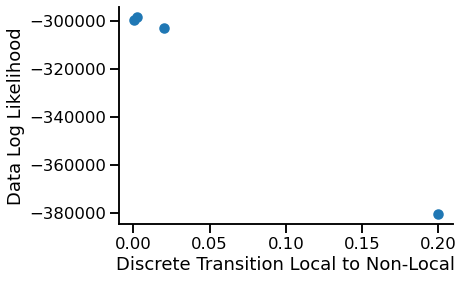

In [14]:
folder_name = 'discrete_transition_local_to_non_local'
os.makedirs(folder_name, exist_ok=True)
data_log_likelihood_clusterless = []

discrete_transition_local_to_non_local = [0.0002, 0.002, 0.02, 0.2]

for i, local_to_non_local in enumerate(discrete_transition_local_to_non_local):
    print(i)
    is_training = ~data['is_ripple'].values.squeeze()

    detector_parameters = {
        'movement_var': 6.0,
        'replay_speed': 1,
        'place_bin_size': 2.0,
        'spike_model_knot_spacing': 12.0,
        'spike_model_penalty': 1E-5,
        'movement_state_transition_type': 'random_walk',
        'multiunit_model_kwargs': {
            'mark_std': 24.0, 'position_std': 4.0, 'block_size': 100},
        'discrete_state_transition_type': 'constant',
        'discrete_diagonal': np.array([local_to_non_local, 0.98])
    }
    detector, results = predict_multiunit(is_training, detector_parameters)
    plot_detector(time_slice, data, detector, results,
                  figsize=(22, 12.0))
    plt.suptitle(f'local_to_non_local = {local_to_non_local}')
    plt.savefig(f'{folder_name}/{i:02d}.png', dpi=100, bbox_inches='tight')
    plt.close()
    data_log_likelihood_clusterless.append(results.data_log_likelihood)
    

plot_likelihood(discrete_transition_local_to_non_local, data_log_likelihood_clusterless)
plt.xlabel('Discrete Transition Local to Non-Local')
plt.savefig(f'{folder_name}/data_log_likelihood.png', dpi=100, bbox_inches='tight')

28-Feb-22 12:09:25 ReplayDetector(discrete_diagonal=array([0.02, 0.9 ]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_ty...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               speed_knots=None, speed_threshold=4.0,
               spike_model_knot_spacing=12.0, sp

0


28-Feb-22 12:09:26 Fitting speed model...
28-Feb-22 12:09:26 Fitting multiunit model...
28-Feb-22 12:09:27 Fitting continuous state transition...
28-Feb-22 12:09:28 Fitting discrete state transition...
28-Feb-22 12:09:28 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 12:15:46 Finding causal non-local probability and position...
28-Feb-22 12:15:56 Finding acausal non-local probability and position...
28-Feb-22 12:16:33 Done!
28-Feb-22 12:16:35 ReplayDetector(discrete_diagonal=array([0.02 , 0.968]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
    

1


28-Feb-22 12:16:35 Fitting speed model...
28-Feb-22 12:16:36 Fitting multiunit model...
28-Feb-22 12:16:37 Fitting continuous state transition...
28-Feb-22 12:16:37 Fitting discrete state transition...
28-Feb-22 12:16:37 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 12:22:52 Finding causal non-local probability and position...
28-Feb-22 12:23:01 Finding acausal non-local probability and position...
28-Feb-22 12:23:35 Done!
28-Feb-22 12:23:37 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

2


28-Feb-22 12:23:38 Fitting speed model...
28-Feb-22 12:23:38 Fitting multiunit model...
28-Feb-22 12:23:39 Fitting continuous state transition...
28-Feb-22 12:23:40 Fitting discrete state transition...
28-Feb-22 12:23:40 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 12:29:53 Finding causal non-local probability and position...
28-Feb-22 12:30:03 Finding acausal non-local probability and position...
28-Feb-22 12:30:37 Done!
28-Feb-22 12:30:39 ReplayDetector(discrete_diagonal=array([0.02, 0.99]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

3


28-Feb-22 12:30:39 Fitting speed model...
28-Feb-22 12:30:40 Fitting multiunit model...
28-Feb-22 12:30:41 Fitting continuous state transition...
28-Feb-22 12:30:42 Fitting discrete state transition...
28-Feb-22 12:30:42 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 12:36:56 Finding causal non-local probability and position...
28-Feb-22 12:37:06 Finding acausal non-local probability and position...
28-Feb-22 12:37:40 Done!


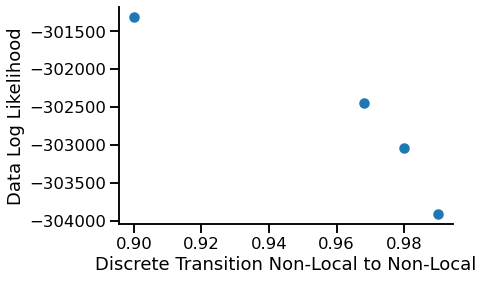

In [16]:
folder_name = 'discrete_transition_non_local_to_non_local'
os.makedirs(folder_name, exist_ok=True)
data_log_likelihood_clusterless = []

discrete_transition_non_local_to_non_local = [0.9, 0.968, 0.98, 0.99]

for i, non_local_to_non_local in enumerate(discrete_transition_non_local_to_non_local):
    print(i)
    is_training = ~data['is_ripple'].values.squeeze()
    
    detector_parameters = {
        'movement_var': 6.0,
        'replay_speed': 1,
        'place_bin_size': 2.0,
        'spike_model_knot_spacing': 12.0,
        'spike_model_penalty': 1E-5,
        'movement_state_transition_type': 'random_walk',
        'multiunit_model_kwargs': {
            'mark_std': 24.0, 'position_std': 4.0, 'block_size': 100},
        'discrete_state_transition_type': 'constant',
        'discrete_diagonal': np.array([0.02, non_local_to_non_local])
    }
    detector, results = predict_multiunit(is_training, detector_parameters)
    plot_detector(time_slice, data, detector, results,
                  figsize=(22, 12.0))
    plt.suptitle(f'non_local_to_non_local = {non_local_to_non_local}')
    plt.savefig(f'{folder_name}/{i:02d}.png', dpi=100, bbox_inches='tight')
    plt.close()
    data_log_likelihood_clusterless.append(results.data_log_likelihood)
    

plot_likelihood(discrete_transition_non_local_to_non_local, data_log_likelihood_clusterless)
plt.xlabel('Discrete Transition Non-Local to Non-Local')
plt.savefig(f'{folder_name}/data_log_likelihood.png', dpi=100, bbox_inches='tight')

28-Feb-22 12:37:42 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 1.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               speed_knots=None, speed_threshold=4.0,
               spike_model_knot_spacing=12.0, spi

0


28-Feb-22 12:37:42 Fitting speed model...
28-Feb-22 12:37:43 Fitting multiunit model...
28-Feb-22 12:37:44 Fitting continuous state transition...
28-Feb-22 12:37:45 Fitting discrete state transition...
28-Feb-22 12:37:45 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 12:44:03 Finding causal non-local probability and position...
28-Feb-22 12:44:13 Finding acausal non-local probability and position...
28-Feb-22 12:44:48 Done!
28-Feb-22 12:44:50 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 2.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

1


28-Feb-22 12:44:50 Fitting speed model...
28-Feb-22 12:44:51 Fitting multiunit model...
28-Feb-22 12:44:52 Fitting continuous state transition...
28-Feb-22 12:44:53 Fitting discrete state transition...
28-Feb-22 12:44:53 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 12:51:27 Finding causal non-local probability and position...
28-Feb-22 12:51:39 Finding acausal non-local probability and position...
28-Feb-22 12:52:15 Done!
28-Feb-22 12:52:17 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

2


28-Feb-22 12:52:18 Fitting multiunit model...
28-Feb-22 12:52:19 Fitting continuous state transition...
28-Feb-22 12:52:19 Fitting discrete state transition...
28-Feb-22 12:52:19 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 12:58:48 Finding causal non-local probability and position...
28-Feb-22 12:58:58 Finding acausal non-local probability and position...
28-Feb-22 12:59:33 Done!
28-Feb-22 12:59:36 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 6.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

3


28-Feb-22 12:59:37 Fitting multiunit model...
28-Feb-22 12:59:38 Fitting continuous state transition...
28-Feb-22 12:59:38 Fitting discrete state transition...
28-Feb-22 12:59:38 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 13:06:11 Finding causal non-local probability and position...
28-Feb-22 13:06:21 Finding acausal non-local probability and position...
28-Feb-22 13:06:55 Done!
28-Feb-22 13:06:57 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 8.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

4


28-Feb-22 13:06:58 Fitting speed model...
28-Feb-22 13:06:59 Fitting multiunit model...
28-Feb-22 13:07:00 Fitting continuous state transition...
28-Feb-22 13:07:00 Fitting discrete state transition...
28-Feb-22 13:07:00 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 13:13:27 Finding causal non-local probability and position...
28-Feb-22 13:13:37 Finding acausal non-local probability and position...
28-Feb-22 13:14:11 Done!


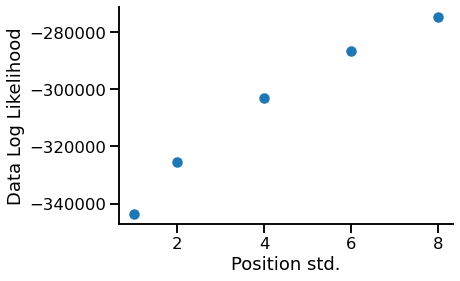

In [17]:
folder_name = 'position_std'
os.makedirs(folder_name, exist_ok=True)
data_log_likelihood_clusterless = []

position_stds = [1.0, 2.0, 4.0, 6.0, 8.0]

for i, position_std in enumerate(position_stds):
    print(i)
    is_training = ~data['is_ripple'].values.squeeze()
    
    detector_parameters = {
        'movement_var': 6.0,
        'replay_speed': 1,
        'place_bin_size': 2.0,
        'spike_model_knot_spacing': 12.0,
        'spike_model_penalty': 1E-5,
        'movement_state_transition_type': 'random_walk',
        'multiunit_model_kwargs': {
            'mark_std': 24.0, 'position_std': position_std, 'block_size': 100},
        'discrete_state_transition_type': 'constant',
        'discrete_diagonal': np.array([0.02, 0.98])
    }
    detector, results = predict_multiunit(is_training, detector_parameters)
    plot_detector(time_slice, data, detector, results,
                  figsize=(22, 12.0))
    plt.suptitle(f'position_std = {position_std}')
    plt.savefig(f'{folder_name}/{i:02d}.png', dpi=100, bbox_inches='tight')
    plt.close()
    data_log_likelihood_clusterless.append(results.data_log_likelihood)
    

plot_likelihood(position_stds, data_log_likelihood_clusterless)
plt.xlabel('Position std.')
plt.savefig(f'{folder_name}/data_log_likelihood.png', dpi=100, bbox_inches='tight')

28-Feb-22 13:14:13 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               speed_knots=None, speed_threshold=4.0,
               spike_model_knot_spacing=12.0, spi

0


28-Feb-22 13:14:14 Fitting speed model...
28-Feb-22 13:14:15 Fitting multiunit model...
28-Feb-22 13:14:16 Fitting continuous state transition...
28-Feb-22 13:14:16 Fitting discrete state transition...
28-Feb-22 13:14:16 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 13:20:47 Finding causal non-local probability and position...
28-Feb-22 13:20:57 Finding acausal non-local probability and position...
28-Feb-22 13:21:32 Done!
28-Feb-22 13:21:34 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

1


28-Feb-22 13:21:34 Fitting speed model...
28-Feb-22 13:21:35 Fitting multiunit model...
28-Feb-22 13:21:36 Fitting continuous state transition...
28-Feb-22 13:21:37 Fitting discrete state transition...
28-Feb-22 13:21:37 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 13:28:08 Finding causal non-local probability and position...
28-Feb-22 13:28:19 Finding acausal non-local probability and position...
28-Feb-22 13:28:58 Done!
28-Feb-22 13:29:00 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

2


28-Feb-22 13:29:00 Fitting speed model...
28-Feb-22 13:29:01 Fitting multiunit model...
28-Feb-22 13:29:02 Fitting continuous state transition...
28-Feb-22 13:29:02 Fitting discrete state transition...
28-Feb-22 13:29:02 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 13:35:35 Finding causal non-local probability and position...
28-Feb-22 13:35:46 Finding acausal non-local probability and position...
28-Feb-22 13:36:24 Done!
28-Feb-22 13:36:26 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

3


28-Feb-22 13:36:26 Fitting speed model...
28-Feb-22 13:36:27 Fitting multiunit model...
28-Feb-22 13:36:28 Fitting continuous state transition...
28-Feb-22 13:36:29 Fitting discrete state transition...
28-Feb-22 13:36:29 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 13:43:01 Finding causal non-local probability and position...
28-Feb-22 13:43:11 Finding acausal non-local probability and position...
28-Feb-22 13:43:46 Done!
28-Feb-22 13:43:48 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

4


28-Feb-22 13:43:49 Fitting speed model...
28-Feb-22 13:43:49 Fitting multiunit model...
28-Feb-22 13:43:51 Fitting continuous state transition...
28-Feb-22 13:43:51 Fitting discrete state transition...
28-Feb-22 13:43:51 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 13:50:19 Finding causal non-local probability and position...
28-Feb-22 13:50:33 Finding acausal non-local probability and position...
28-Feb-22 13:51:13 Done!
28-Feb-22 13:51:15 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

5


28-Feb-22 13:51:15 Fitting speed model...
28-Feb-22 13:51:16 Fitting multiunit model...
28-Feb-22 13:51:17 Fitting continuous state transition...
28-Feb-22 13:51:17 Fitting discrete state transition...
28-Feb-22 13:51:17 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 13:57:46 Finding causal non-local probability and position...
28-Feb-22 13:57:57 Finding acausal non-local probability and position...
28-Feb-22 13:58:37 Done!


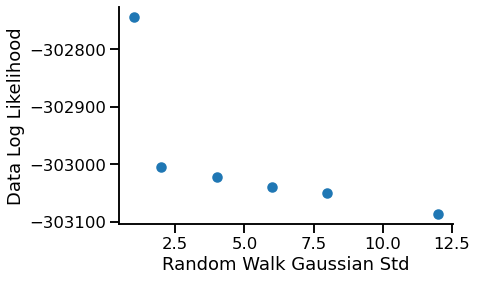

In [18]:
folder_name = 'movement_var'
os.makedirs(folder_name, exist_ok=True)
data_log_likelihood_clusterless = []

movement_vars = [1.0, 2.0, 4.0, 6.0, 8.0, 12.0]

for i, movement_var in enumerate(movement_vars):
    print(i)
    is_training = ~data['is_ripple'].values.squeeze()
    
    detector_parameters = {
        'movement_var': movement_var,
        'replay_speed': 1,
        'place_bin_size': 2.0,
        'spike_model_knot_spacing': 12.0,
        'spike_model_penalty': 1E-5,
        'movement_state_transition_type': 'random_walk',
        'multiunit_model_kwargs': {
            'mark_std': 24.0, 'position_std': 4.0, 'block_size': 100},
        'discrete_state_transition_type': 'constant',
        'discrete_diagonal': np.array([0.02, 0.98])
    }
    detector, results = predict_multiunit(is_training, detector_parameters)
    plot_detector(time_slice, data, detector, results,
                  figsize=(22, 12.0))
    plt.suptitle(f'movement_var = {movement_var}')
    plt.savefig(f'{folder_name}/{i:02d}.png', dpi=100, bbox_inches='tight')
    plt.close()
    data_log_likelihood_clusterless.append(results.data_log_likelihood)
    

plot_likelihood(movement_vars, data_log_likelihood_clusterless)
plt.xlabel('Random Walk Gaussian Std')
plt.savefig(f'{folder_name}/data_log_likelihood.png', dpi=100, bbox_inches='tight')

In [19]:
from src.load_data import get_descending_theta

gnd_lfp, theta_filtered_lfp, is_descending = get_descending_theta(data['tetrode_info'], data['position_info'])

28-Feb-22 15:19:23 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               speed_knots=None, speed_threshold=4.0,
               spike_model_knot_spacing=12.0, spi

0


28-Feb-22 15:19:24 Fitting speed model...
28-Feb-22 15:19:24 Fitting multiunit model...
28-Feb-22 15:19:25 Fitting continuous state transition...
28-Feb-22 15:19:26 Fitting discrete state transition...
28-Feb-22 15:19:26 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 15:25:59 Finding causal non-local probability and position...
28-Feb-22 15:26:13 Finding acausal non-local probability and position...
28-Feb-22 15:26:48 Done!
28-Feb-22 15:26:50 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

1


28-Feb-22 15:26:51 Fitting speed model...
28-Feb-22 15:26:52 Fitting multiunit model...
28-Feb-22 15:26:53 Fitting continuous state transition...
28-Feb-22 15:26:53 Fitting discrete state transition...
28-Feb-22 15:26:53 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 15:33:08 Finding causal non-local probability and position...
28-Feb-22 15:33:18 Finding acausal non-local probability and position...
28-Feb-22 15:33:56 Done!
28-Feb-22 15:33:58 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
     

2


28-Feb-22 15:33:58 Fitting speed model...
28-Feb-22 15:33:59 Fitting multiunit model...
28-Feb-22 15:34:00 Fitting continuous state transition...
28-Feb-22 15:34:00 Fitting discrete state transition...
28-Feb-22 15:34:00 Predicting multiunit likelihood...


n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

28-Feb-22 15:38:16 Finding causal non-local probability and position...
28-Feb-22 15:38:26 Finding acausal non-local probability and position...
28-Feb-22 15:38:59 Done!


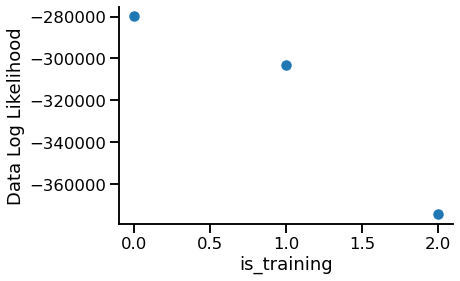

In [30]:
folder_name = 'is_training'
os.makedirs(folder_name, exist_ok=True)
data_log_likelihood_clusterless = []


for i in range(3):
    print(i)
    if i == 0:
        is_training = np.ones_like(~data['is_ripple'].values.squeeze())
    elif i == 1:
        is_training = ~data['is_ripple'].values.squeeze()
    elif i == 2:
        is_training = ((~data['is_ripple'].values.squeeze()) & (data['position_info'].nose_vel.values.squeeze() <= 4)) | (is_descending & (data['position_info'].nose_vel > 4))
    
    detector_parameters = {
        'movement_var': 6.0,
        'replay_speed': 1,
        'place_bin_size': 2.0,
        'spike_model_knot_spacing': 12.0,
        'spike_model_penalty': 1E-5,
        'movement_state_transition_type': 'random_walk',
        'multiunit_model_kwargs': {
            'mark_std': 24.0, 'position_std': 4.0, 'block_size': 100},
        'discrete_state_transition_type': 'constant',
        'discrete_diagonal': np.array([0.02, 0.98])
    }
    detector, results = predict_multiunit(is_training, detector_parameters)
    plot_detector(time_slice, data, detector, results,
                  figsize=(22, 12.0))
    if i == 0:
        plt.suptitle(f'is_training = all')
    elif i == 1:
        plt.suptitle(f'is_training = not ripples')
    elif i == 2:
        plt.suptitle(f'is_training = not ripples and on descending theta while running')
    plt.savefig(f'{folder_name}/{i:02d}.png', dpi=100, bbox_inches='tight')
    plt.close()
    data_log_likelihood_clusterless.append(results.data_log_likelihood)
    

plot_likelihood(range(3), data_log_likelihood_clusterless)
plt.xlabel('is_training')
plt.savefig(f'{folder_name}/data_log_likelihood.png', dpi=100, bbox_inches='tight')

01-Mar-22 10:07:15 ReplayDetector(discrete_diagonal=array([0.02, 0.98]),
               discrete_state_transition_penalty=1e-05,
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_t...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 4.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               speed_knots=None, speed_threshold=4.0,
               spike_model_knot_spacing=12.0, spi

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/28 [00:00<?, ?it/s]

01-Mar-22 10:13:51 Finding causal non-local probability and position...
01-Mar-22 10:14:02 Finding acausal non-local probability and position...
01-Mar-22 10:14:40 Done!


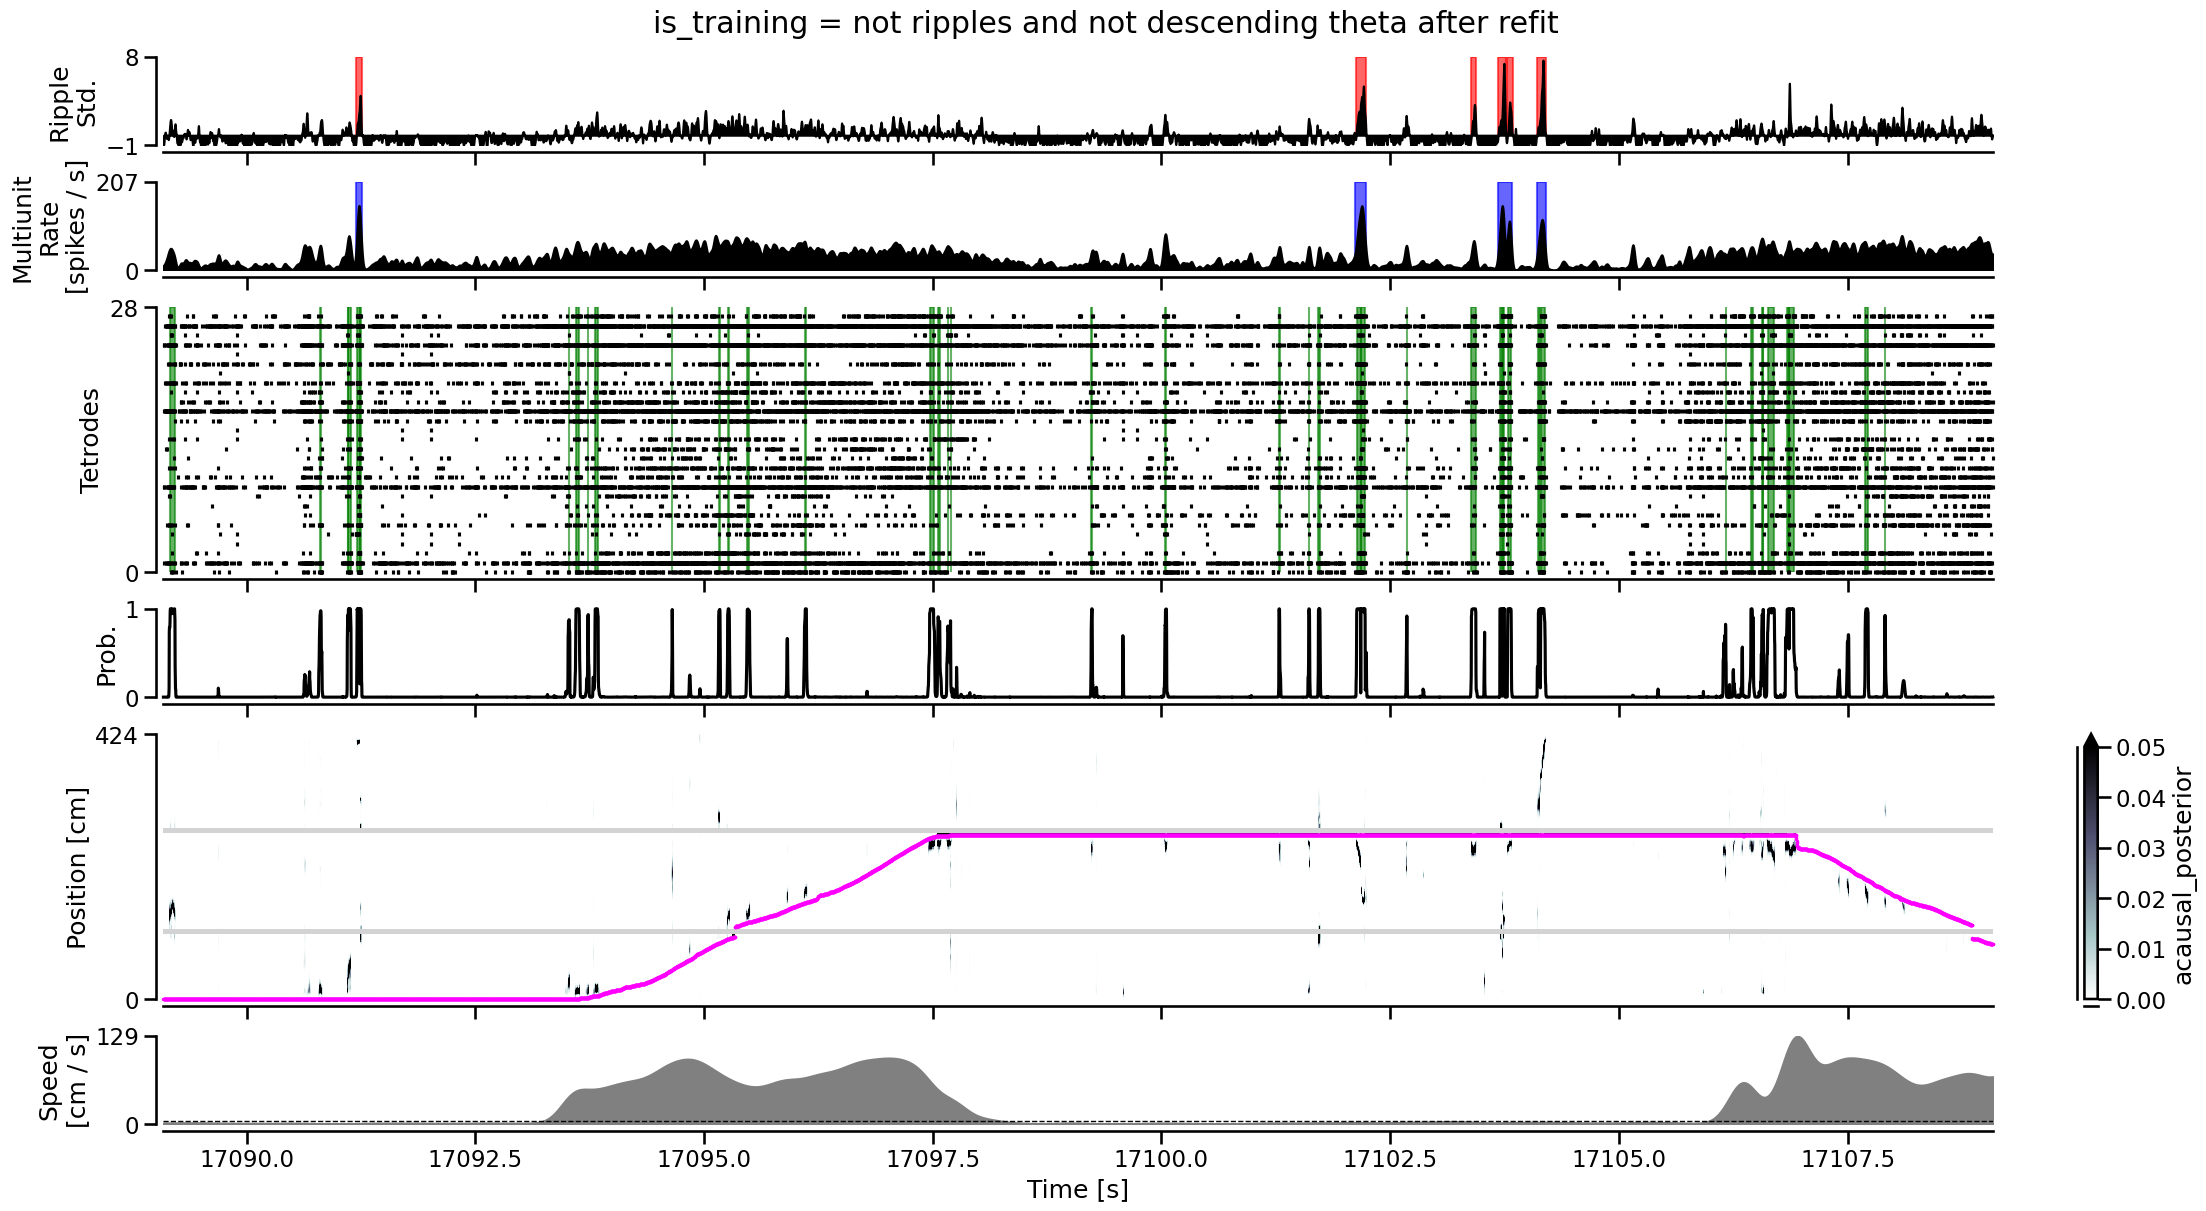

In [32]:
detector, results = predict_multiunit((1 - results.non_local_probability.values).squeeze(), detector_parameters)
plot_detector(time_slice, data, detector, results,
              figsize=(22, 12.0))
plt.suptitle(f'is_training = not ripples and not descending theta after refit')
i = 3
plt.savefig(f'{folder_name}/{i:02d}.png', dpi=100, bbox_inches='tight')